In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, BatchNormalization, TimeDistributed

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import gensim
from gensim.utils import simple_preprocess

#import multiprocessing as mp
from multiprocessing import cpu_count

# set working directory
path = '/Users/ianlo/Documents/Data Analyitcs & Data Science/Deep Learning Developer Course/RNNProject/'
os.chdir(path)

# import custom files
from LossLearningRateScheduler import LossLearningRateScheduler

import utils as utils
import global_settings as gs
from parallelproc import applyParallel

In [41]:
# tokenizer: can change this as needed
tokenize = lambda x: simple_preprocess(x)

# set no of groups for partitioning
_number_of_groups = int(cpu_count()*0.8)

# set no of threads
_cpu = int(cpu_count()*0.8)

# initialise global parameters
gs.init()

# max no. of words in a review
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 20

Read in xls file, remove duplicates and create index for parallel processing

In [42]:
# -----------------------------------------------------------------------------
# extract all the reviews from the XLS files into a data frame
i=1
rows = pd.DataFrame()
while i <= 1:
    rw = utils.readXlsx("./data/Train/hotel_sentiment_v01.xlsx", sheet = i, header=True)
    # extend takes the content of another list and adds it into that list
    rows = rows.append(rw, ignore_index=True)
    i += 1
    
df = pd.DataFrame(rows)

# remove no longer used objects in memory
del rw, rows

# remove duplicate entries
df = df.dropna().drop_duplicates()

# create index for easy parallel processing
df['indx'] = df.index
df.insert(0,'grpId',df.apply(lambda row: row.indx % _number_of_groups, axis=1, raw=True))
# drop the temp indx column
df = df.drop('indx', 1)

The following steps are used to clean the text and execute the following pre-processing:
- Change all text to lower case
- Split words that happen to be joined together without a ' '. This has an effect of surfacing words which would have otherwise been scored very low becuase it only appears once in the entire corpus
- Remove custom stopwords

In [43]:
print('Starting pre-processing: Clean')
df = applyParallel(df.groupby(df.grpId), utils.clean_text, {"dest_col_ind": df.shape[1]-1, "dest_col": "processed_text", "src_col": "review_text"}, _cpu)

print('Starting pre-processing: Lower case')
df = applyParallel(df.groupby(df.grpId), utils.lower_case, {"dest_col_ind": df.shape[1]-1, "dest_col": "processed_text", "src_col": "processed_text"}, _cpu)

print('Starting pre-processing: Restructure text')
df = applyParallel(df.groupby(df.grpId), utils.restructureText, {"dest_col_ind": df.shape[1]-1, "dest_col": "processed_text", "src_col": "processed_text"}, _cpu)

print('Starting pre-processing: Remove custom stop words')
df = applyParallel(df.groupby(df.grpId), utils.remove_stopwords, {"dest_col_ind": df.shape[1]-1, "dest_col": "processed_text", "src_col": "processed_text"}, _cpu)

Starting pre-processing: Clean
Starting pre-processing: Lower case
Starting pre-processing: Restructure text
Starting pre-processing: Remove custom stop words


In [44]:
# =============================================================================
# find the word frequency and remove non frequent words

# the list of words from the corpus that has more than 10 instances
# this list will be used to tag the sentences with PAD, EOS, UNK
wordlist = utils.get_words_by_freq(df['processed_text'], 10)
wordlist.append('PAD')
wordlist.append('EOS')
wordlist.append('UNK')

# substitute everything not in wordlist with PAD, EOS, UNK
max_features = 23413
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['processed_text'].values)
X = tokenizer.texts_to_sequences(df['processed_text'].values)
X = pd.DataFrame(pad_sequences(X, padding='post', truncating='post', maxlen = MAX_SEQUENCE_LENGTH))

# get the word index from the tokenizer
word_index = tokenizer.word_index
word_index['PAD'] = 0
word_index['EOS'] = len(word_index)

# create index to word list so that we can update the padded sentences with the 
# special charaters needed
# create index to word dictionary
index_word = {}
for word in word_index.keys():
    if word in wordlist:
        index_word[word_index.get(word)] = word
    else:
        index_word[word_index.get(word)] = 'UNK'

In [45]:
# this section marks the EOS with the index from word_index['EOS'], PAD with index from word_index['PAD] and UNK
# create special dictionary for faster replacement of tokens in sentences
temp = {}
for word in word_index.keys():
    if word in wordlist:
        temp[word_index.get(word)] = word_index.get(word)
    else:
        temp[word_index.get(word)] = word_index.get(word) # this is really meaningless but this is a short hack from experimenting

# add PAD and EOS to the index_word list
#temp[0] = 'PAD'
#temp[len(word_index)] = 'EOS' 
temp[0] = word_index['PAD']
temp[len(word_index)] = word_index['EOS']


# replace tokens in sentences
X = X.apply(lambda y: y.map(lambda x: temp.get(x,x)), axis=1)


# mark the first PAD with EOS to indicate end of sentence
def set_eos(row):
#    row.iloc[list(row).index('PAD') if 'PAD' in list(row) else -1] = word_index['EOS']
    row.iloc[list(row).index(0) if 0 in list(row) else -1] = word_index['EOS']
    return row

X = X.apply(lambda y: set_eos(y), axis=1)


In [46]:
# one hot encode target
enc1 = OneHotEncoder()
Y = pd.DataFrame(enc1.fit_transform(pd.DataFrame(df.iloc[:,4])).toarray())


# create train / test set
x_train, x_valid, y_train, y_valid = train_test_split(X,
                                                      Y,
                                                      test_size = 0.15,
                                                      random_state = gs.seedvalue)

In [47]:
# load a word2vec from google news
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)  

# create a vocab based on the google news vectors model
vocab = dict([(k, v.index) for k, v in model.vocab.items()])

In [48]:
# create the embeddings_index so that we can get the embeddings from the google model
# for each word
embeddings_index = {}
# if word is not found in the google vector then set to 0
# otherwise the embeddings_index will have the corresponding google news vector embedding for
# the specific word found in the review text
for word in word_index.keys():
    if vocab.get(word) is not None:
        embeddings_index[word] = model.syn0[vocab.get(word)]
    else:
        embeddings_index[word] = [0] * 300 # default size of google news vector embeddings


pad_embed=np.empty(300, dtype=float); pad_embed.fill(0.001) 
eos_embed=np.empty(300, dtype=float); eos_embed.fill(0.999)
unk_embed=np.empty(300, dtype=float); unk_embed.fill(0.555) 
embeddings_index['PAD'] = pad_embed
embeddings_index['EOS'] = eos_embed
embeddings_index['UNK'] = unk_embed


# embedding_dimension is the size of the vector
embedding_dimension = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)[:embedding_dimension]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:embedding_dimension]

Create class weights based on the distribution of each class to handle imbalanced classes

In [49]:
import math
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    #keys = labels_dict.keys()
    class_weight = dict()

    #for key in keys:
    for key, value in labels_dict.items():
        #score = math.log(mu*total/float(labels_dict[key]))
        score = math.log(mu*total/float(value))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

# random labels_dict
labels_dict = {0: 832, 1: 904, 2: 2114, 3: 3584, 4: 6422}
classweights = create_class_weight(labels_dict, mu=0.5)
classweights

{0: 2.1194940094210626,
 1: 2.0364970898500947,
 2: 1.1869892838120881,
 3: 1.0,
 4: 1.0}

In [50]:
lstm_out = 1024

# create the model
model = Sequential()
model.add(Embedding(max_features, embedding_dimension, input_length = x_train.shape[1], weights=[embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4)))
#model.add(Dense(1024, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

# setting up the optimization of our weights
#sgd = keras.optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
#nadam = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          7023900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300, 2048)         10854400  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 2048)              25174016  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 43,062,561
Trainable params: 43,062,561
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

batch_size = 32
hist = model.fit(np.array(x_train), np.array(y_train),
                 epochs = EPOCHS, batch_size=BATCH_SIZE, verbose = 1,
                 validation_data=(np.array(x_valid), np.array(y_valid)),
                 shuffle=True,
                 class_weight=classweights,
                 callbacks = [keras.callbacks.History(),
                              LossLearningRateScheduler(base_lr = 0.001,
                                                        lookback_epochs = 3,
                                                        decay_multiple = 0.75)])

In [ ]:
model.save('hotel-sentiment-model.hdf5')

In [51]:
# reload model to ensure that the model is saved successfully and can be subsequently read
model = load_model('hotel-sentiment-model-07543.hdf5')

In [52]:
preds = model.predict(np.array(x_valid), batch_size=None, verbose=1)

1905/1905 [==============================] - 783s   


In [53]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
preds = np.argmax(preds, axis=1)

In [55]:
y_valid = np.argmax(np.array(y_valid), axis=1)

In [56]:
class_names = np.unique(y_valid) + 1

Confusion matrix, without normalization
[[ 71  24   7   3   1]
 [ 16  92  22   8   1]
 [  5  25 171  63  14]
 [  1   8  40 309  92]
 [  1   3   8 126 794]]


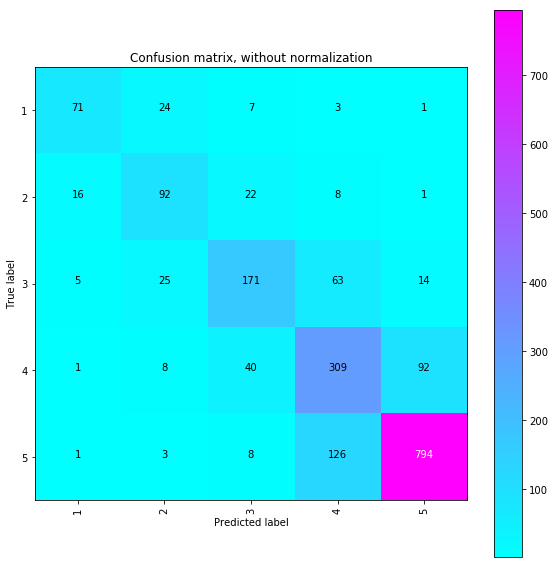

In [57]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_valid, preds)
#cnf_matrix = confusion_matrix(y, x)
np.set_printoptions(precision=2)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(8, 8)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()